In [1]:
from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers
from keras import utils
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import sys
import datetime
import time



Using TensorFlow backend.


In [2]:
import telegram
from keras.callbacks import Callback
from callbacks import TelegramCallback
from callbacks.TelegramData import TelegramData


# create callback
config = {
    'token': TelegramData.Token,   # paste your bot token
    'telegram_id': TelegramData.ID,                                   # paste your telegram_id
}

tg_callback = TelegramCallback(config)

In [3]:
class LoggingTensorBoard(TensorBoard):    

    def __init__(self, log_dir, settings_str_to_log, **kwargs):
        super(LoggingTensorBoard, self).__init__(log_dir, **kwargs)

        self.settings_str = settings_str_to_log

    def on_train_begin(self, logs=None):
        TensorBoard.on_train_begin(self, logs=logs)

        tensor =  tf.convert_to_tensor(self.settings_str)
        summary = tf.summary.text ("Run_Settings", tensor)

        with  tf.Session() as sess:
            s = sess.run(summary)
            self.writer.add_summary(s)

In [4]:
train_ids = [1, 2, 3, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17]
test_ids = [4, 5, 6, 11]

In [5]:
# the data, split between train and test sets
dfAll = pd.read_pickle("PklData/df_blobs.pkl")
#df_train = dfAll[(dfAll.userID != 1) | (dfAll.userID != 2)]
#df_test = dfAll[(dfAll.userID == 1) | (dfAll.userID == 2)]
df_train = dfAll[dfAll.userID.isin(train_ids)]
df_test = dfAll[dfAll.userID.isin(test_ids) & (dfAll.Version == "Normal")]

df_test = df_test.reset_index()
df_train = df_train.reset_index()

df_train2 = df_train[['Blobs', 'InputMethod']].copy()
df_test2 = df_test[['Blobs', 'InputMethod']].copy()

In [6]:
dfAll.userID.unique()

array([15,  3,  7, 16,  5,  9, 17, 14,  6, 10,  2,  4, 12,  1, 13,  8, 11])

In [7]:
x_train = np.vstack(df_train2.Blobs)
x_test = np.vstack(df_test2.Blobs)
y_train = df_train2.InputMethod.values
y_test = df_test2.InputMethod.values

x_train = x_train.reshape(-1, 27, 15, 1)
x_test = x_test.reshape(-1, 27, 15, 1)

In [10]:
x_train[0].shape

(27, 15, 1)

In [9]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = 2
y_train_one_hot = utils.to_categorical(df_train2.InputMethod, num_classes)
y_test_one_hot = utils.to_categorical(df_test2.InputMethod, num_classes)

Text(0.5, 1.0, 'Label for image 1 is: 0')

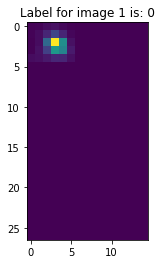

In [10]:
i = 1
plt.imshow(x_train[i].reshape(27, 15)) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, y_train[i]))

In [11]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
#config = tf.ConfigProto(device_count = {"GPU": 1})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.1

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [12]:
tf.get_default_graph()
########## HYPER PARAMETERS

batch_size = 500
epochs = 400
optimizer = optimizers.Adam(lr=0.001)
#optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)
#init=tf.global_variables_initializer()

########## HYPER PARAMETERS
########## MODEL ARCHITECTURE
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(27,15,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last'))
model.add(Dropout(0.50))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last'))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(0.02, 0.15), use_bias=True))
model.add(Dropout(0.50))
model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(0.02, 0.15), use_bias=True))
model.add(Dropout(0.50))
model.add(Dense(num_classes, activation='softmax'))
########## MODEL ARCHITECTURE
####TENSORBOARD
config = ""
for layer in model.layers:
    config += str(layer.output).split('\"')[1].split("/")[0] + str(layer.output_shape) + "\n\n"
#### END TENSORBOARD
config += "batchsize: " + str(batch_size) + "\n\n" + "epochs: " + str(epochs) + "\n\n"

# Print summary
model.summary()
readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
tensorflowfolder = "/srv/share/tensorboardfiles/KnuckleFinger_Robin_" + readable_timestamp
print("KnuckleFinger_Robin_" + readable_timestamp)
logger = LoggingTensorBoard(settings_str_to_log = config, log_dir=tensorflowfolder, histogram_freq=0,
                            write_graph=True, write_images=True, update_freq = 'epoch')
storer = ModelCheckpoint("./ModelSnapshots/KnuckleFinger_Robin_" + readable_timestamp + ".h5", monitor='val_loss', verbose=0,
                         save_best_only=True, save_weights_only=False, mode='auto', period=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.9, 
                                            min_lr=0.00001)
# compile model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test_one_hot),
                    callbacks=[logger, storer, learning_rate_reduction, tg_callback])
                    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 15, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 15, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 15, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 8, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 8, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 8, 32)         18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 8, 32)         9248      
__________

290344/290344 [==============================] - 28s 96us/step - loss: 0.5794 - acc: 0.9511 - val_loss: 0.6848 - val_acc: 0.9184
Epoch 97/400
290344/290344 [==============================] - 28s 96us/step - loss: 0.5821 - acc: 0.9512 - val_loss: 0.6609 - val_acc: 0.9182
Epoch 98/400
290344/290344 [==============================] - 28s 96us/step - loss: 0.5796 - acc: 0.9511 - val_loss: 0.6542 - val_acc: 0.9207
Epoch 99/400
290344/290344 [==============================] - 28s 96us/step - loss: 0.5812 - acc: 0.9509 - val_loss: 0.7303 - val_acc: 0.9194
Epoch 100/400
290344/290344 [==============================] - 28s 96us/step - loss: 0.5833 - acc: 0.9511 - val_loss: 0.6923 - val_acc: 0.9221
Epoch 101/400
290344/290344 [==============================] - 28s 96us/step - loss: 0.5859 - acc: 0.9510 - val_loss: 0.6744 - val_acc: 0.9234

Epoch 00101: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
Epoch 102/400
290344/290344 [==============================] - 28s 96us/step -

290344/290344 [==============================] - 27s 95us/step - loss: 0.3431 - acc: 0.9598 - val_loss: 0.4854 - val_acc: 0.9192
Epoch 207/400
290344/290344 [==============================] - 27s 94us/step - loss: 0.3412 - acc: 0.9602 - val_loss: 0.4696 - val_acc: 0.9222
Epoch 208/400
290344/290344 [==============================] - 27s 95us/step - loss: 0.3417 - acc: 0.9598 - val_loss: 0.4772 - val_acc: 0.9218
Epoch 209/400
290344/290344 [==============================] - 27s 94us/step - loss: 0.3405 - acc: 0.9601 - val_loss: 0.5056 - val_acc: 0.9191
Epoch 210/400
290344/290344 [==============================] - 27s 94us/step - loss: 0.3416 - acc: 0.9599 - val_loss: 0.4897 - val_acc: 0.9220

Epoch 00210: ReduceLROnPlateau reducing learning rate to 0.0002824295632308349.
Epoch 211/400
290344/290344 [==============================] - 27s 94us/step - loss: 0.3202 - acc: 0.9599 - val_loss: 0.4775 - val_acc: 0.9206
Epoch 212/400
290344/290344 [==============================] - 27s 94us/ste

290344/290344 [==============================] - 27s 95us/step - loss: 0.1988 - acc: 0.9641 - val_loss: 0.3752 - val_acc: 0.9199
Epoch 317/400
290344/290344 [==============================] - 27s 95us/step - loss: 0.2005 - acc: 0.9643 - val_loss: 0.3400 - val_acc: 0.9198
Epoch 318/400
290344/290344 [==============================] - 27s 95us/step - loss: 0.2004 - acc: 0.9636 - val_loss: 0.3587 - val_acc: 0.9220
Epoch 319/400
290344/290344 [==============================] - 27s 95us/step - loss: 0.1990 - acc: 0.9645 - val_loss: 0.3604 - val_acc: 0.9218
Epoch 320/400
290344/290344 [==============================] - 28s 95us/step - loss: 0.1989 - acc: 0.9642 - val_loss: 0.3335 - val_acc: 0.9236
Epoch 321/400
290344/290344 [==============================] - 27s 95us/step - loss: 0.1999 - acc: 0.9639 - val_loss: 0.3565 - val_acc: 0.9218
Epoch 322/400
290344/290344 [==============================] - 27s 94us/step - loss: 0.1995 - acc: 0.9643 - val_loss: 0.3675 - val_acc: 0.9204
Epoch 323/400

In [ ]:
def cnn_model():
    optimizer = optimizers.Adam()
    #optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)
    #init=tf.global_variables_initializer()

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(27,15,1)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last'))
    model.add(Dropout(0.50))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last'))
    model.add(Dropout(0.50))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(0.02, 0.15), use_bias=True))
    model.add(Dropout(0.50))
    model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(0.02, 0.15), use_bias=True))
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation='softmax'))
    ########## MODEL ARCHITECTURE
    ####TENSORBOARD
    config = ""
    for layer in model.layers:
        config += str(layer.output).split('\"')[1].split("/")[0] + str(layer.output_shape) + "\n\n"
    #### END TENSORBOARD
    config += "batchsize: " + str(batch_size) + "\n\n" + "epochs: " + str(epochs) + "\n\n"

    # Print summary
    model.summary()
    readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
    tensorflowfolder = "/srv/share/tensorboardfiles/KnuckleFinger_Robin_" + readable_timestamp
    print("KnuckleFinger_Robin_" + readable_timestamp)
    logger = LoggingTensorBoard(settings_str_to_log = config, log_dir=tensorflowfolder, histogram_freq=0,
                                write_graph=True, write_images=True, update_freq = 'epoch')
    storer = ModelCheckpoint("./ModelSnapshots/KnuckleFinger_Robin_" + readable_timestamp + ".h5", monitor='val_loss', verbose=0,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                                patience=10, 
                                                verbose=1, 
                                                factor=0.95, 
                                                min_lr=0.00001)
    # compile model for training
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train_one_hot,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test_one_hot),
                        callbacks=[ storer,tg_callback, learning_rate_reduction])


In [ ]:
# use model for inference to get test accuracy
y_test_pred = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_test, y_test_pred))

print ('\n Confusion matrix: ')
print (sklearn.metrics.confusion_matrix(y_test, y_test_pred))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], label="Test Accuracy")
plt.plot(history.history['acc'], label="Training Accuracy")
plt.legend()
plt.ylim(0.5,1)
plt.savefig("pres.jpg")

In [17]:
# save model
model.save("10_01_19.h5")

In [16]:
model.predict(x_train, batch_size=500, verbose=0)

array([[9.8380899e-01, 1.6190920e-02],
       [9.9928612e-01, 7.1396033e-04],
       [9.8458582e-01, 1.5414230e-02],
       ...,
       [7.4371819e-05, 9.9992561e-01],
       [1.7390951e-07, 9.9999988e-01],
       [1.8832952e-06, 9.9999809e-01]], dtype=float32)

In [78]:
y_train_one_hot

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [85]:
train_prediction=np.round(model.predict(x_train))
train_prediction=train_prediction.astype(int)

In [122]:
val_prediction=np.round(model.predict(x_test))
val_prediction=val_prediction.astype(int)

In [123]:
delta = val_prediction - y_test_one_hot
indices = []
for i in range(len(val_prediction)):
    if np.count_nonzero(delta[i]) > 0:
        indices += [i]

In [125]:
len(indices)

3545

In [2]:
imagelist = []
for data_point in indices:
    print(data_point)
    plt.close()
    plt.clf()
    plt.cla()
    #plt.subplot(figsize=(6,6))
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    
    
    
    data_point = indices[0]
    data = df_train.Blobs.iloc[data_point]
    label = "Knuckle" if train_prediction[data_point][0] == 1 else "Finger"  
    ax.set_title("Input method: " + str(df_train.InputMethod.iloc[data_point]) + "\n" + "Label as: "  + label)
    #plt.imsave("PredictionImages/" + str(data_point)+".pdf", data, cmap='gray', vmin=0, vmax=255)
    plt.imsave("PredictionImages/{}.png".format(data_point), data, cmap="gray", vmin=0, vmax=255)
    #plt.close()


NameError: name 'indices' is not defined

In [117]:
from fpdf import FPDF

In [38]:
incorrects

array([1, 0, 1, ..., 1, 1, 0])